# Random forest classification

**What does this notebook do?** This notebook classifies remote sensing data using a random forest classifier model. Key features include being able to efficiently import training data from a set of point, line or polygon shapefiles (i.e. data is extracted from each shapefile separately to avoid slow 'dc.load' on large areas), and allow flexible and consistent selection of training and analysis data using import functions (i.e. ensuring training data is consistent with analysis data). The notebook exports geotiff classification outputs and a series of evaluation figures to help fine-tune the classifier.

**Date:** March 2018

**Author:** Robbi Bishop-Taylor

**Tags:**

# Set up analysis
Defines parameters used for analysis. Note: 'data_func' and 'data_func_params' need to be set at step 5 if changing remote sensing data source used for training and classification

In [ ]:
###########################################
# For HLTC-based mangrove classification: #
###########################################

# List of training files to import. Shapefiles can be either points, lines or polygons, 
# but must be in the same projection system as the remote sensing dataset being analysed. 
# Each file should cover a small enough spatial area so as to not slow dc.load function 
# excessively (e.g. 100 x 100km max)
train_shps = ["raw_data/train/training_data_mangrove.shp",
              "raw_data/train/training_data_mangrove1.shp",
              "raw_data/train/training_data_mangrove2.shp",
              "raw_data/train/training_data_mangrove3.shp"]

# Output path for classified geotiff
classification_output = "output_data/classification_dc_mangrove.tif"

# Optional dict to re-map training shapefile classes; useful for combining classes
# ('3:2' re-maps class 3 to class 2)
# train_reclass = {1:1, 2:2, 3:2, 4:2}
train_reclass = None

# Names of output classification classes
# classification_names = ["mangrove", "other"]
classification_names = ["mangrove", "water", "veg", "other"]


In [82]:
##########################################
# For Tasseled cap-based classification: #
##########################################

# # List of training files to import. Shapefiles can be either points, lines or polygons, 
# # but must be in the same projection system as the remote sensing dataset being analysed. 
# # Each file should cover a small enough spatial area so as to not slow dc.load function 
# # excessively (e.g. 100 x 100km max)
# train_shps = ["raw_data/train/training_data_tasseledcap.shp"]

# # Output path for classified geotiff
# classification_output = "output_data/classification_dc_tasseledcap.tif"

# # Optional dict to re-map training shapefile classes; useful for combining classes
# # ('3:2' re-maps class 3 to class 2)
# train_reclass = None

# # Names of output classification classes
# classification_names = ["wetland", "escarpment", "plateau", "other_wetland"]


# Import modules

In [64]:
# Load modules
import datacube
import fiona
import glob
import itertools
import matplotlib
import os
import rasterio
import warnings
import pandas as pd
import rasterio.features
import xarray as xr
import numpy as np
from collections import OrderedDict
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_invalid_data
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib import pyplot as plt
from osgeo import gdal
from os.path import splitext
from shapely.geometry import Point
from shapely.geometry import shape
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.tree import export_graphviz
from sklearn.tree import _tree 

# For nicer notebook plotting, hide warnings (comment out for real analysis)
warnings.filterwarnings('ignore') 

# Set up datacube instance
dc = datacube.Datacube(app = 'Random forest classification')


def load_nbart(sensor, query):
    
    '''
    Loads nbart data for a sensor, mask by pq and filter terrain -999s.
    Modified from original function written by B Dunn (2017).
    
    :attr sensor: Landsat sensor to import (valid options: 'ls5', 'ls7', 'ls8')
    :attr query: complete datacube query used to import data
    
    :returns: xarray dataset matching query
    '''  
    
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('Loading {}'.format(product_name))
    ds = dc.load(product = product_name,
                 group_by = 'solar_day', 
                 **query)
    
    if ds:       
   
        print('Loaded {}'.format(product_name))
        
        # Extract PQ data for masking
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product = mask_product, 
                            fuse_func = ga_pq_fuser,
                            group_by = 'solar_day', 
                            **query)
        
        if sensor_pq:
            
            print('Making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca = 'no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask = 'no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous = True)
            
            # Filter to remove clouds and -999 terrain issues
            ds = ds.where(cloud_free)
            ds = ds.where(ds != -999.0)
            
            # Add projection attributes
            ds.attrs['crs'] = ds.crs
            ds.attrs['affine'] = ds.affine    
            ds.attrs['geo_transform'] = ds.geobox.transform.to_gdal()
            ds.attrs['proj'] = ds.geobox.crs.wkt
            print('Masked {} with {} and filtered ' \
                  'terrain'.format(product_name, mask_product))
            
        else: 
            
            print('Did not mask {} with {}'.format(product_name, mask_product))
            
    else:
        
        print ('Did not load {}'.format(product_name)) 

    if len(ds) > 0:
        
        return ds
    
    else:
        
        return None


def rasterize_vector(input_data, cols, rows, geo_transform,
                     projection, field):
    
    """
    Rasterize a vector file and return numpy array
    
    :attr input_data: input shapefile path or preloaded GDAL/OGR layer
    :attr cols: width of output array in columns
    :attr rows: height of output array in rows
    :attr geo_transform: geotransform for rasterization
    :attr projection: projection for rasterization
    :attr field: shapefile field to take values from
    
    :returns: a 'row x col' array containg values from vector
    """
    
    # If input data is a string, import as shapefile layer
    if isinstance(input_data, str):    
    
        # Open vector with gdal
        data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
        input_data = data_source.GetLayer(0)
    
    # Set up output raster
    driver = gdal.GetDriverByName('GTiff')  #'MEM')  # In memory dataset
    target_ds = driver.Create('test.tif', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    
    # Rasterize shapefile and extract array
    gdal.RasterizeLayer(target_ds, [1], input_data, options=["ATTRIBUTE=" + field])
    band = target_ds.GetRasterBand(1)
    out_array = band.ReadAsArray()
    target_ds = None
    
    return out_array


def write_geotiff(fname, data, geo_transform, projection, nodata_val):
    
    """
    Create a single band GeoTIFF file with data from array.
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster
    :attr projection: projection for output raster
    :attr nodata_val: value to convert to nodata in output raster
    """
    
    # Set up driver
    driver = gdal.GetDriverByName('GTiff')
    
    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    
    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)
    
    # Close file
    dataset = None     
    

def tasseled_cap(sensor_data, sensor, tc_bands = ['greenness', 'brightness', 'wetness'], 
                 drop = True):
    
    """
    Computes tasseled cap wetness, greenness and brightness bands from a six
    band xarray dataset, and returns a new xarray dataset with old bands 
    optionally dropped.
    
    Coefficients for demonstration purposes only; sourced from:
    Landsat 5: https://doi.org/10.1016/0034-4257(85)90102-6
    Landsat 7: https://doi.org/10.1080/01431160110106113
    Landsat 8: https://doi.org/10.1080/2150704X.2014.915434
    
    :attr sensor_data: input xarray dataset with six Landsat bands
    :attr tc_bands: list of tasseled cap bands to compute 
    (valid options: 'wetness', 'greenness','brightness'
    :attr sensor: Landsat sensor used for coefficient values 
    (valid options: 'ls5', 'ls7', 'ls8')
    :attr drop: if 'drop = False', return all original Landsat bands 
    
    :returns: xarray dataset with newly computed tasseled cap bands
    """
    
    # Copy input dataset
    output_array = sensor_data.copy(deep = True)
 
    # Coefficients for each tasseled cap band
    wetness_coeff = {'ls5':{'blue':0.0315, 'green':0.2021, 'red':0.3102, 
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                     'ls7':{'blue':0.2626, 'green':0.2141, 'red':0.0926, 
                            'nir':0.0656, 'swir1':-0.7629, 'swir2':-0.5388},
                     'ls8':{'blue':0.1511, 'green':0.1973, 'red':0.3283, 
                            'nir':0.3407, 'swir1':-0.7117, 'swir2':-0.4559}}
    
    greenness_coeff = {'ls5':{'blue':-0.1603, 'green':-0.2819, 'red':-0.4934, 
                              'nir':0.7940, 'swir1':-0.0002, 'swir2':-0.1446},
                       'ls7':{'blue':-0.3344, 'green':-0.3544, 'red':-0.4556, 
                              'nir':0.6966, 'swir1':-0.0242, 'swir2':-0.2630},
                       'ls8':{'blue':-0.2941, 'green':-0.2430, 'red':-0.5424, 
                              'nir':0.7276, 'swir1':-0.0713, 'swir2':-0.1608}}
    
    brightness_coeff = {'ls5':{'blue':0.2043, 'green':0.4158, 'red':0.5524, 
                               'nir':0.5741, 'swir1':0.3124, 'swir2':0.2303},
                        'ls7':{'blue':0.3561, 'green':0.3972, 'red':0.3904, 
                               'nir':0.6966, 'swir1':0.2286, 'swir2':0.1596},
                        'ls8':{'blue':0.3029, 'green':0.2786, 'red':0.4733, 
                               'nir':0.5599, 'swir1':0.508, 'swir2':0.1872}}
    
    # Dict to use correct coefficients for each tasseled cap band
    analysis_coefficient = {'wetness': wetness_coeff, 
                            'greenness': greenness_coeff,
                            'brightness': brightness_coeff}
    
    # For each band, compute tasseled cap band and add to output dataset
    for tc_band in tc_bands:

        # Create xarray of coefficient values used to multiply each band of input
        coeff = xr.Dataset(analysis_coefficient[tc_band][sensor])    
        sensor_coeff = sensor_data * coeff

        # Sum all bands
        output_array[tc_band] = sensor_coeff.blue + sensor_coeff.green + \
                                sensor_coeff.red + sensor_coeff.nir + \
                                sensor_coeff.swir1 + sensor_coeff.swir2
    
    # If drop = True, remove original bands
    if drop:
        
        bands_to_drop = list(sensor_data.data_vars)        
        output_array = output_array.drop(bands_to_drop)        

    return(output_array)


def layer_extent(layer):
    
    """
    Computes min and max extents for GDAL layer features. Compared to
    built-in ".GetExtent" that always returns unfiltered extents, this 
    allows you to compute extents of features within filtered layers 
    (e.g. layers filtered with 'SetAttributeFilter'). Works for point,
    line and polygon features, returning the extent of feature centroids 
    for lines and polygon datasets.
    """
    
    # Extract tuples of x, y, z coordinates for each point feature
    point_coords = [feature.geometry().Centroid().GetPoint() for feature in layer]
    
    # Compute mins and maxes across points for each tuple element
    max_x, max_y, max_z = map(min, zip(*point_coords))
    min_x, min_y, min_z = map(max, zip(*point_coords))    
    
    return  min_x, max_x, min_y, max_y


def randomforest_train(train_shps, train_field, data_func, data_func_params = {},
                       classifier_params = {}, train_reclass = None):
    
    '''
    Extracts training data from xarray dataset for multiple training shapefiles.
    Loops through each each training shapefile, using shapefile extent for spatial
    query. Outputs a trained classifier object and training label and data arrays.
    
    :attr train_shps: list of training shapefile paths to import. Each file 
    should cover a small enough spatial area so as to not slow dc.load function 
    excessively (e.g. 100 x 100km max)
    :attr train_field: shapefile field containing classification class
    :attr data_func: function to import xarray data for each shapefile. Should return 
    an xarray dataset with 'geo_transform' and 'proj' attributes
    :attr data_func_params: optional dict of dc.load query inputs. Useful for defining 
    time query for temporal datasets (spatial queries are set automatically from shapefiles)
    :attr classifier_params: optional dict of parameters for training random forest
    :attr train_reclass: optional dict of from:to pairs to re-map shapefile field classes. 
    Useful for simplifying multiple classes into a simpler set of classes
    
    :returns: trained classifier
    :returns: array of training labels
    :returns: array of training data
    '''

    # Output training label and pixel arrays
    training_labels_list = list()
    training_samples_list = list()

    # For each shapefile, extract datacube data using extent of points
    # and add resulting spectral data and labels to list of arrays
    for train_shp in train_shps:
        
        print("Importing training data from {}:".format(train_shp))
        
        try:

            # Open vector of training points with gdal
            data_source = gdal.OpenEx(train_shp, gdal.OF_VECTOR)
            layer = data_source.GetLayer(0)      

            # Compute extents and generate spatial query
            xmin, xmax, ymin, ymax = layer_extent(layer) 
            query_train = {'x': (xmin + 2000, xmax - 2000),
                           'y': (ymin + 2000, ymax - 2000),
                           'crs': 'EPSG:3577',
                           **data_func_params}        
            print(query_train)

            # Import data  as xarray and extract projection/transform data
            training_xarray = data_func(query_train)
            geo_transform_train = training_xarray.geo_transform
            proj_train = training_xarray.proj 

            # Covert to array and rearrange dimension order
            bands_array_train = training_xarray.to_array().values
            bands_array_train = np.einsum('bxy->xyb', bands_array_train)
            rows_train, cols_train, bands_n_train = bands_array_train.shape

            # Import training data shapefiles and convert to matching raster pixels
            training_shapefile = train_shp
            training_pixels = rasterize_vector(layer, cols_train, rows_train, 
                                               geo_transform_train, proj_train, 
                                               field = train_field)  

            # Extract matching image sample data for each labelled pixel location
            is_train = np.nonzero(training_pixels)
            training_labels = training_pixels[is_train]
            training_samples = bands_array_train[is_train]

            # Remove nans from training samples
            training_labels = training_labels[~np.isnan(training_samples).any(axis=1)]
            training_samples = training_samples[~np.isnan(training_samples).any(axis=1)]

            # Append outputs
            training_labels_list.append(training_labels)
            training_samples_list.append(training_samples)
        
        except AttributeError:
            
            print("  Skipping training data from {}; check file path".format(train_shp))

    # Combine polygon training data    
    training_labels = np.concatenate(training_labels_list, axis=0)
    training_samples = np.concatenate(training_samples_list, axis=0)  
    
    # Optionally re-map classes prior to classification training
    if train_reclass:
        
        # For each class in training labels, re-map to new values using train_reclass
        training_labels[:] = [train_reclass[label] for label in training_labels]
    
    # Set up classifier and train on training sample data and labels
    # Options for tuning: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
    print("\nTraining random forest classifier...")
    classifier = RandomForestClassifier(**classifier_params) 
    classifier.fit(training_samples, training_labels)
    print("Model trained on {0} bands and "
          "{1} training samples".format(training_samples.shape[1],
                                        str(len(training_samples))))
    
    return classifier, training_labels, training_samples


def randomforest_classify(classifier, analysis_data, classification_output, class_prob = False):
    
    '''
    Performs classification of xarray dataset using pre-trained random forest classifier, 
    and export classified output to a geotiff. Optionally, also export a predicted class 
    probability raster (i.e. indicating fraction of samples of the predicted class in a leaf)
    
    :attr classifier: random forest classifier generated using randomforest_train
    :attr analysis_data: xarray dataset with 'geo_transform' and 'proj' attributes
    and the same number of bands as data used to train classifier
    :attr classification_output: file path to output geotiff classification 
    :attr class_prob: if True, compute predicted class probability and export to 
    geotiff suffixed with "_prob.tif"
    
    :returns: classified array and (optional) classification probability array
    '''

    geo_transform = analysis_data.geo_transform
    proj = analysis_data.proj 

    # Covert to array and rearrange dimension order
    analysis_array = analysis_data.to_array().values
    analysis_array = np.einsum('bxy->xyb', analysis_array)
    rows, cols, bands_n = analysis_array.shape
    print("Data to classify:\n  Rows: {0}\n  Columns: {1}\n  Bands: {2}".format(rows, cols, bands_n))

    # Remove nodata and return flattened 'pixel x bands' array
    input_nodata = np.isnan(analysis_array).any(axis = 2)
    flat_pixels = analysis_array[~input_nodata]

    # Run classification
    print("\nClassification processing...")
    result = classifier.predict(flat_pixels)

    # Restore 2D array by assigning flattened output to empty array
    classification = np.zeros((rows, cols))
    classification[~input_nodata] = result

    # Nodata removed
    print("  {} nodata cells removed".format(str(np.sum(classification == 0))))

    # Export to file
    write_geotiff(classification_output, 
                  data = classification, 
                  geo_transform = geo_transform, 
                  projection = proj,
                  nodata_val = 0)
    print("  Classification exported")  
    
    # If requested, export classification probability:
    if class_prob:    
    
        # Compute predicted class probability (fraction of samples of same class in a leaf)
        # Use max to return only highest probability (the one that determined output class)
        print("\nClass probability processing...")
        result_prob = classifier.predict_proba((flat_pixels))
        result_prob = np.max(result_prob, axis = 1) * 100.0 

        # Restore 2D array by assigning flattened output to empty array
        classification_prob = np.zeros((rows, cols))
        classification_prob[~input_nodata] = result_prob

        # Export to file
        write_geotiff(splitext(classification_output)[0] + "_prob.tif", 
                      data = classification_prob, 
                      geo_transform = geo_transform, 
                      projection = proj,
                      nodata_val = -999)
        print("  Class probability exported")
        
        return classification, classification_prob
    
    else:
        
        return classification, None

    
def randomforest_eval(training_labels, training_samples, classifier_scenario, 
                      output_path, max_estimators = 100):
    
    """
    Takes a set of training labels and training samples, and plots OOB error against
    a range of classifier parameters to explore how parameters affect classification.
    
    :attr training_labels: an (X, ) array of training labels
    :attr training_samples: an (X, B) array of training sample data
    :attr classifier_scenario: dict of classifier scenarios to plot
    :attr output_path: output path for plot of OOB error by scenario
    :attr max_estimators: max number of estimators to plot on x-axis (default = 100)
    """

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in classifier_scenario)

    # Range of `n_estimators` values to explore.
    min_estimators = 1

    for label, clf in classifier_scenario:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators = i)
            clf.fit(train_samp, train_lab)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label = label)
        
    # Plot and save output as figure
    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc = "upper right")
    plt.yscale('log')    
    plt.savefig(output_path, bbox_inches = 'tight')
    plt.show()


# Functions used to import training and analysis data
Both of these functions import datacube data using a query, and return an xarray dataset with multiple bands/variables and 'geo_transform' and 'proj' attributes. 
This format is required as an input to both 'randomforest_train' and 'randomforest_classify' to ensure that both training and analysis data are consistent.

In [65]:
def hltc_import(query):
    
    """
    Imports high and low composite data for a given spatial query, and
    return an xarray dataset with 'geo_transform' and 'proj' attributes 
    
    :attr query: spatial query for datacube.load()
    :returns: xarray dataset with 'geo_transform' and 'proj' attributes
    """

    # Import data
    low_tide = dc.load(product = 'low_tide_comp_20p', **query)
    high_tide = dc.load(product = 'high_tide_comp_20p', **query)

    # Rename variables in each high/low composite so datasets can be merged
    data_vars = list(low_tide.data_vars)
    low_tide.rename({var: "lt_" + var for var in data_vars}, inplace = True)
    high_tide.rename({var: "ht_" + var for var in data_vars}, inplace = True)

    # Combine into one dataset
    output_xarray = xr.auto_combine([low_tide, high_tide]).isel(time = 0)
    
    # Set attributes   
    output_xarray.attrs['proj'] = low_tide.geobox.crs.wkt
    output_xarray.attrs['geo_transform'] = low_tide.geobox.transform.to_gdal()    
    
    return output_xarray


def tc_import(query):
    
    '''
    Wrapper around load_nbart and tasseled cap to return an xarray dataset with 
    'geo_transform' and 'proj' attributes
    
    :attr query: query for datacube call; for training, supply only
    non-spatial queries as spatial are generated from training data
    :returns: xarray dataset with 'geo_transform' and 'proj' attributes
    '''
    
    # Import cleaned Landsat bands data
    nbar_example = load_nbart('ls8', query)
    
    # Compute tasseled cap indices and take median of multiple timesteps
    output_xarray = tasseled_cap(sensor_data = nbar_example, 
                                 sensor = 'ls8',
                                 drop = True).median("time", keep_attrs = True)
    
    return output_xarray        


# Import training data and fit model
Uses 'randomforest_train' to extract training data from potentially multiple training shapefiles, and returns a trained classifier (and optionally, training label and training sample arrays)

In [66]:
# Dict of classifier parameters
classifier_params = {'n_jobs': -1,                                    
                     'n_estimators': 100,
                     'max_features': "auto",
                     'min_samples_leaf': 1,
                     'oob_score': True }

# Set data function used to import data and optional parameters (e.g. time for temporal data).
# For example, 'tc_import' needs an additional 'time' query as it draws on Landsat time-series 
# data, while 'hltc_import' uses high-low tide composites that have no temporal dimension
data_func = hltc_import
data_func_params = {}
# data_func = tc_import
# data_func_params = {'time': ('2017-03-01', '2017-06-28')}

# Extract training data for each training shapefile and train classifier
classifier, train_lab, train_samp = randomforest_train(train_shps = train_shps,
                                                       train_field = "class",
                                                       data_func = data_func,
                                                       data_func_params = data_func_params,
                                                       classifier_params = classifier_params,
                                                       train_reclass = train_reclass)


Importing training data from raw_data/train/training_data_mangrove.shp:
{'x': (-96195.37617727809, -159027.5762163046), 'y': (-1293746.4245350992, -1349139.5474466463), 'crs': 'EPSG:3577'}
Importing training data from raw_data/train/training_data_mangrove1.shp:
{'x': (-248822.2628674942, -269215.4139100249), 'y': (-1570514.9681683218, -1590991.9822624666), 'crs': 'EPSG:3577'}
Importing training data from raw_data/train/training_data_mangrove2.shp:
{'x': (-216770.8137106544, -237605.05985552695), 'y': (-1630468.8744477245, -1646265.5913745423), 'crs': 'EPSG:3577'}
Importing training data from raw_data/train/training_data_mangrove3.shp:
{'x': (-699112.9082409441, -724416.739027992), 'y': (-1612261.936734104, -1634952.3249203684), 'crs': 'EPSG:3577'}

Training random forest classifier...
Model trained on 12 bands and 352 training samples


# Import analysis data and classify
Classifies and exports an analysis dataset using a previously trained random forest classifier, provided this dataset has the same number of bands/variables as the data used to train the classifier. Using the same data function used to train the classifier (e.g. 'data_func' previously defined as either 'tc_import' or 'hltc_import') will ensure this is the case. By setting 'class_prob = True', can optionally export a geotiff of predicted class probabilities in addition to the classification output.

Data to classify:
  Rows: 4001
  Columns: 4001
  Bands: 12

Classification processing...
  0 nodata cells removed
  Classification exported

Class probability processing...
  Class probability exported


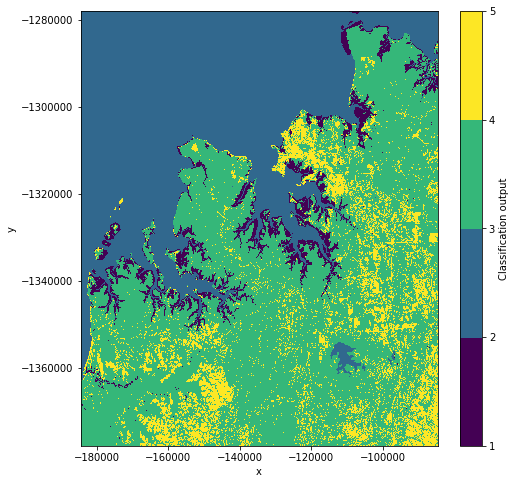

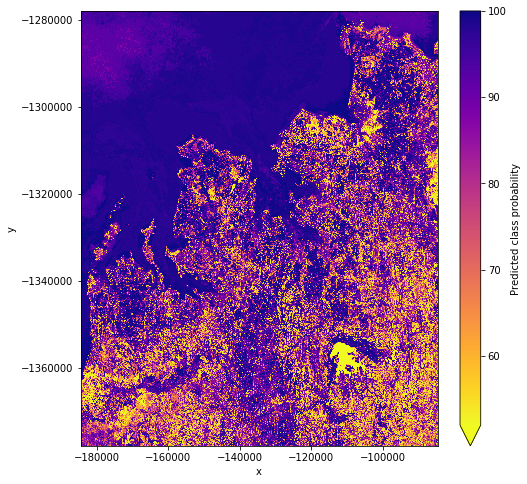

In [109]:
# Set up analysis data query
lat_point, lon_point, buffer = -12.5798399926, 130.782907919, 50000
x, y = geometry.point(lon_point, lat_point, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),         
         'crs': 'EPSG:3577',
          **data_func_params}

# Load data from datacube
analysis_xarray = data_func(query)

# Run classification and export to file   
class_array, prob_array = randomforest_classify(classifier = classifier,
                                                analysis_data = analysis_xarray,
                                                classification_output = classification_output,
                                                class_prob = True)

# Plot output classification
class_xarray = xr.DataArray(class_array, 
                   coords = [analysis_xarray.y, analysis_xarray.x], 
                   dims = ['y', 'x'],
                   name = "Classification output")
class_xarray.plot(levels = list(np.unique(class_array)) + [len(np.unique(class_array)) + 1], 
                               figsize = (8, 8))

# Plot predicted class probability (proportion of trees agreeing with classification)
plt.plot()
prob_xarray = xr.DataArray(prob_array, 
                           coords = [analysis_xarray.y, analysis_xarray.x], 
                           dims = ['y', 'x'],
                           name = "Predicted class probability")
prob_xarray.plot(cmap = "plasma_r", figsize = (8, 8),  
                 vmin = np.percentile(prob_array, 3), 
                 vmax = np.percentile(prob_array, 97))


# Feature/band/variable importance
Extract classifier estimates of the relative importance of each band/variable for training the classifier. Useful for potentially selecting a subset of input bands/variables for model training/classification (i.e. optimising feature space)

,importance
variable,
lt_blue,0.078837
lt_green,0.047461
lt_red,0.041073
lt_nir,0.070420
lt_swir1,0.065832
lt_swir2,0.124902
ht_blue,0.065044
ht_green,0.058947
ht_red,0.038579


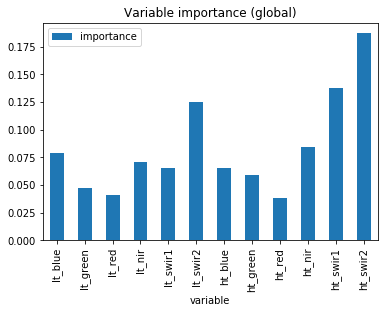

In [79]:
#  Extract feature importances from trained classifier
importance = classifier.feature_importances_
importance_df = pd.DataFrame({'variable': analysis_xarray.data_vars,
                              'importance': importance})
importance_df.set_index("variable", inplace = True)
importance_df.plot.bar(title = "Variable importance (global)")
display(importance_df)


# Plot performance of model by parameter values
Random forest classifiers contain many modifiable parameters that can strongly affect the performance of the model. This section evaluates the effect of these parameters by plotting out-of-bag (OOB) error for a set of classifier parameter scenarios, and exports the resulting plots to file.

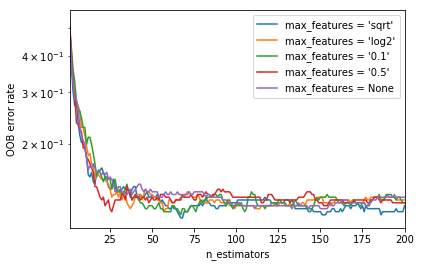

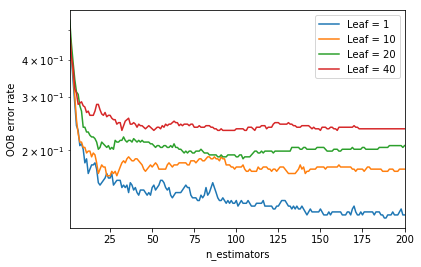

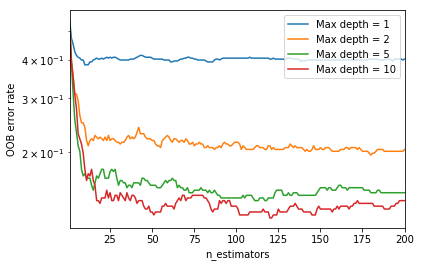

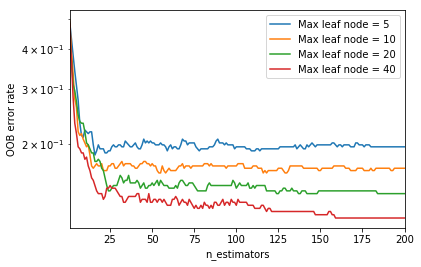

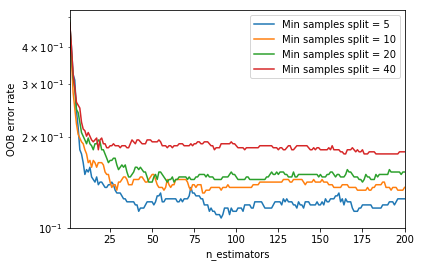

In [80]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

# Test effect of max features
classifier_scenario1 = [("max_features = 'sqrt'",
                        RandomForestClassifier(warm_start = True,
                                               oob_score = True,
                                               max_features = "sqrt")),
                       ("max_features = 'log2'",
                        RandomForestClassifier(warm_start = True, 
                                               oob_score = True,
                                               max_features = "log2")),
                        
                       ("max_features = '0.1'",
                        RandomForestClassifier(warm_start = True, 
                                               max_features = 0.1,
                                               oob_score = True)),
                        
                       ("max_features = '0.5'",
                        RandomForestClassifier(warm_start = True, 
                                               max_features = 0.5,
                                               oob_score = True)),
                       ("max_features = None",
                        RandomForestClassifier(warm_start = True,
                                               max_features = None,
                                               oob_score = True))]

# Test effect of minimum samples per leaf
classifier_scenario2 = [("Leaf = 1",
                         RandomForestClassifier(warm_start = True,
                                                min_samples_leaf = 1,
                                                oob_score = True)),                       
                       ("Leaf = 10",
                        RandomForestClassifier(warm_start = True,
                                               min_samples_leaf = 10,
                                               oob_score = True)),                       
                       ("Leaf = 20",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_leaf = 20,
                                               oob_score = True)),
                       ("Leaf = 40",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_leaf = 40,
                                               oob_score = True))]

# Test effect of max depth
classifier_scenario3 = [("Max depth = 1",
                         RandomForestClassifier(warm_start = True,
                                                max_depth = 1,
                                                oob_score = True)),                       
                       ("Max depth = 2",
                        RandomForestClassifier(warm_start = True,
                                               max_depth = 2,
                                               oob_score = True)),                       
                       ("Max depth = 5",
                        RandomForestClassifier(warm_start = True, 
                                               max_depth = 5,
                                               oob_score = True)),                       
                       ("Max depth = 10",
                        RandomForestClassifier(warm_start = True, 
                                               max_depth = 10,
                                               oob_score = True))]

# Test effect of max leaf node
classifier_scenario4 = [("Max leaf node = 5",
                         RandomForestClassifier(warm_start = True,
                                                max_leaf_nodes = 5,
                                                oob_score = True)),                       
                       ("Max leaf node = 10",
                        RandomForestClassifier(warm_start = True,
                                               max_leaf_nodes = 10,
                                               oob_score = True)),                       
                       ("Max leaf node = 20",
                        RandomForestClassifier(warm_start = True, 
                                               max_leaf_nodes = 20,
                                               oob_score = True)),                       
                       ("Max leaf node = 40",
                        RandomForestClassifier(warm_start = True, 
                                               max_leaf_nodes = 40,
                                               oob_score = True))]

# Test effect of max leaf node
classifier_scenario5 = [("Min samples split = 5",
                         RandomForestClassifier(warm_start = True,
                                                min_samples_split = 5,
                                                oob_score = True)),                       
                       ("Min samples split = 10",
                        RandomForestClassifier(warm_start = True,
                                               min_samples_split = 10,
                                               oob_score = True)),                       
                       ("Min samples split = 20",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_split = 20,
                                               oob_score = True)),                       
                       ("Min samples split = 40",
                        RandomForestClassifier(warm_start = True, 
                                               min_samples_split = 40,
                                               oob_score = True))]

# Produce figures and export plots for each set of classification scenarios
for i, classifier_scenario in enumerate([classifier_scenario1, 
                                         classifier_scenario2, 
                                         classifier_scenario3,
                                         classifier_scenario4,
                                         classifier_scenario5]):
    
    # Plot OOB error by classifier scenario
    randomforest_eval(training_labels = train_lab, 
                      training_samples = train_samp, 
                      classifier_scenario = classifier_scenario,
                      output_path = "figures/random_forest_params_{}.png".format(i + 1),
                      max_estimators = 200)


# Export tree diagrams
Export .png plots of each decision tree in the random forest ensemble. Useful for inspecting the splits used by the classifier to classify the data.

In [6]:
# Plot output random forest trees to file
for n, tree_in_forest in enumerate(classifier.estimators_):    

    # Create graph and save to dot file
    export_graphviz(tree_in_forest,
                    out_file = "figures/tree_graphs/tree.dot",
                    feature_names = list(analysis_xarray.data_vars),
                    class_names = classification_names,
                    filled = True,
                    rounded = True)

    # Plot as figure
    os.system('dot -Tpng figures/tree_graphs/tree.dot -o ' + \
              'figures/tree_graphs/tree' + str(n + 1) + '.png')    
